# Compressor de Imagens

### Inicialização de bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fftpack
import matplotlib.image as mpimg
from collections import Counter
import pickle
import os

### Funções Auxiliares

In [2]:
def get_2d_dct(img):
    """ Get 2D Cosine Transform of Image
    """
    return fftpack.dct(fftpack.dct(img.T, norm='ortho').T, norm='ortho')

def get_2d_idct(coefficients):
    """ Get 2D Inverse Cosine Transform of Image
    """
    return fftpack.idct(fftpack.idct(coefficients.T, norm='ortho').T, norm='ortho')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def psnr(predictions, targets):
    rmsev = rmse(predictions, targets)
    return 20 * np.log10(255/rmsev)

def calcEntropy(img):
    hist = cv2.calcHist([img],[0],None,[256],[0,256])
    hist = hist.ravel()/hist.sum()
    logs = np.log2(hist+0.00001)
    entropy = -1 * (hist*logs).sum()

    return entropy

def calcHist(list):
    
    dictionary = {}

    for i in list:
        if dictionary.get(i) == None:
            dictionary[i] = 1
        else:
            dictionary[i] = dictionary[i]+1
            
    return dictionar

def compress_dict(dictionary):
    new_dictionary = dict()
    
    for key in dictionary.keys():
        binary_value = dictionary[key]
        new_dictionary[key] = (len(binary_value), int(binary_value, 2))
        
    return new_dictionary

def decompress_dict(dictionary):
    decomp_dict = dict()
    
    get_bin = lambda x, n: format(x, 'b').zfill(n)
    
    for key in dictionary.keys():
        int_representation = dictionary[key]
        decomp_dict[key] = get_bin(int_representation[1], int_representation[0])
        
    return decomp_dict

### Matriz de Quantização

In [3]:
# aplicação da tabela de quantização
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

# quantization matrix
QM = np.matrix([[16, 11, 10, 16, 24, 40, 51, 61], 
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QM = QM.astype(float)

### Funções principais

In [4]:
def dct(img_path):
    img = cv2.imread(img_path,0)
    img = img.astype(float)
    step = 8
    size = img.shape
    
    new_size = (size[0] + (8 - (size[0]%8))%8, size[1] + (8 - (size[1]%8))%8)
    new_img = np.zeros(new_size)
    new_img[0:size[0], 0:size[1]] = img
    
    DCT = np.zeros(new_img.shape, dtype=np.float64)
    
    new_img = new_img-128
    
    for y in range(0,new_size[0],step):
        for x in range(0,new_size[1],step):
            dct = get_2d_dct(new_img[y:y+step, x:x+step])
            dct = np.divide(dct, QM)
            dct = dct.round()
            DCT[y:y+step, x:x+step] = dct
    
    return img, DCT, size

def idct(DCT, shape):
    size = DCT.shape
    step = 8
    IDCT = np.zeros(DCT.shape, dtype=np.float64)
    
    for y in range(0,size[0],step):
        for x in range(0,size[1],step):
            dct = np.multiply(DCT[y:y+step, x:x+step], QM)
            IDCT[y:y+step, x:x+step] = get_2d_idct(dct)

    IDCT = IDCT + 128
    
    IDCT = IDCT[0:shape[0], 0:shape[1]]
    
    return IDCT

def zigzag(DCT):
    step = 8
    
    vector = []

    for x in range(0, DCT.shape[0], step):
        for y in range(0, DCT.shape[1], step):
            local = DCT[x:x+8, y:y+8]

            (i,j) = (0,0)

            while i < 8 and j < 8:
                vector.append(int(local[i,j]))
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1
    
    return vector

def DeZigZag(vector, shape):
    
    step = 8
    reconstruct = np.zeros(shape, dtype=np.float64)
    index = 0

    for x in range(0, shape[0], step):
        for y in range(0, shape[1], step):

            (i,j) = (0,0)

            while i < 8 and j < 8:
                reconstruct[x+i,y+j] = vector[index]
                index = index+1
                # subida
                if (i+j)%2 == 0:
                    # borda esquerda da matriz
                    if j == 7:
                        i = i+1
                        continue
                    # borda superior da matriz
                    if i == 0:
                        j = j+1
                        continue
                    i = i-1
                    j = j+1

                #descida
                else:
                    # borda inferior da matriz
                    if i == 7:
                        j = j+1
                        continue
                    # borda direita da matriz
                    if j == 0:
                        i = i+1
                        continue
                    i = i+1
                    j = j-1

    return reconstruct

def lossless_predictive(vector):
    aux = [vector[0]]
    
    for i in range(1,len(vector)):
        aux.append(vector[i]-vector[i-1])
        
    return aux

def undo_lossless_predictive(vector):
    reconstruct = [vector[0]]
    
    for i in range(1,len(vector)):
        reconstruct.append(reconstruct[-1]+vector[i])
        
    return reconstruct

In [5]:
#https://www.javatpoint.com/huffman-coding-using-python#:~:text=Huffman%20coding%20is%20a%20lossless,utilized%20for%20lossless%20data%20compression.

# Node of a Huffman Tree  
class Nodes:  
    def __init__(self, probability, symbol, left = None, right = None):  
        # probability of the symbol  
        self.probability = probability  
  
        # the symbol  
        self.symbol = symbol  
  
        # the left node  
        self.left = left  
  
        # the right node  
        self.right = right  
  
        # the tree direction (0 or 1)  
        self.code = ''
        
def CalculateCodes(node,  dictionary, value = ''): 
    # a huffman code for current node  
    newValue = value + str(node.code)  
  
    if(node.left):  
        CalculateCodes(node.left, dictionary, newValue)  
    if(node.right):  
        CalculateCodes(node.right, dictionary, newValue)  
  
    if(not node.left and not node.right):  
        dictionary[node.symbol] = newValue  
           
    return dictionary

def HuffmanEncoding(the_data):  
    symbolWithProbs = calcHist(the_data)
    the_symbols = symbolWithProbs.keys()
    the_probabilities = symbolWithProbs.values()
    
    the_nodes = []
      
    # converting symbols and probabilities into huffman tree nodes  
    for symbol in the_symbols:  
        the_nodes.append(Nodes(symbolWithProbs.get(symbol), symbol))

      
    while len(the_nodes) > 1:  
        # sorting all the nodes in ascending order based on their probability  
        the_nodes = sorted(the_nodes, key = lambda x: x.probability)

        # picking two smallest nodes  
        right = the_nodes[0]
        left = the_nodes[1]
      
        left.code = 0 
        right.code = 1
      
        # combining the 2 smallest nodes to create new node  
        newNode = Nodes(left.probability + right.probability, left.symbol + right.symbol, left, right)
      
        the_nodes.remove(left)
        the_nodes.remove(right)
        the_nodes.append(newNode)
        
    the_codes = dict()
              
    huffmanEncoding = CalculateCodes(the_nodes[0], the_codes)
    return huffmanEncoding

In [6]:
def encodeData(data, codes):
    encoded_data = []
    
    for value in data:
        encoded_data.append(codes[value])
        
    encoded_string = ''.join(encoded_data)
    
    size = len(encoded_string)
    
    for i in range(8-(size%8)):
        encoded_string += '0'
    
    return encoded_string

def bin2string(bin_string):
    bin2char = lambda x : chr(int(x,2))
    
    aux = bin_string
    
    if(len(bin_string)%8):
        for i in range(8-(len(bin_string)%8)):
            aux += '0'
    
    char_string = ''
    
    for i in range(0, len(aux), 8):
        char_string += bin2char(bin_string[i:i+8])
    
    return char_string

def string2bin(char_string):
    char2bin = lambda x : format(ord(x), 'b').zfill(8)
    
    aux = ''

    for i in char_string:
        aux += char2bin(i)
        
    return aux

def reverseEncode(codes):
    reverseCodes = dict()
    
    for key in codes.keys():
        reverseCodes[codes[key]] = key
        
    return reverseCodes

def decodeData(encoded_data, decoding_codes, size):
    data = []
    counter = 0
    
    for i in range(size):
        aux = ''
        while(decoding_codes.get(aux) == None):
            aux += encoded_data[counter]
            counter+=1
        data.append(decoding_codes[aux])
    
    return data

### Implementação

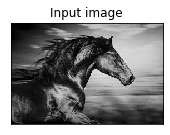

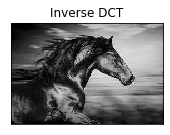

RMSE: 6.361
PSNR: 32.060


In [13]:
def encode(img_path, compressed_file_path):
    #primeiro encoding
    img, DCT, original_shape = dct(img_path)
    vector = zigzag(DCT)
    predictive = lossless_predictive(vector)
    codes = HuffmanEncoding(predictive)
    encoded_bin_string = encodeData(predictive, codes)
    encoded_char_string = bin2string(encoded_bin_string)
    first_encode_size = len(encoded_char_string)

    #segundo encoding
    codes_2 = HuffmanEncoding(encoded_char_string)
    encoded_bin_string_2 = encodeData(encoded_char_string, codes_2)
    encoded_char_string_2 = bin2string(encoded_bin_string_2)
    
    core_values = dict()
    core_values['Data'] = encoded_char_string_2
    core_values['First Encoding Codes'] = compress_dict(codes)
    core_values['First Encode Size'] = first_encode_size
    core_values['Second Encoding Codes'] = compress_dict(codes_2)
    core_values['Original Shape'] = original_shape
    
    with open(compressed_file_path, 'wb') as file:
        pickle.dump(core_values, file)
    
    return compressed_file_path, img

def decode(compressed_file_path):
    
    with open(compressed_file_path, 'rb') as file:
        core_values = pickle.load(file)
    
    encoded_char_string_2 = core_values['Data']
    codes = decompress_dict(core_values['First Encoding Codes'])
    first_encode_size = core_values['First Encode Size']
    codes_2 = decompress_dict(core_values['Second Encoding Codes'])
    original_shape = core_values['Original Shape']
    
    dct_shape = (original_shape[0] + (8 - (original_shape[0]%8))%8, original_shape[1] + (8 - (original_shape[1]%8))%8)
    
    #decoding do segundo encoding
    decoding_values_2 = reverseEncode(codes_2)
    decoded_bin_string_2 = string2bin(encoded_char_string_2)
    decoded_char_list_2 = decodeData(decoded_bin_string_2, decoding_values_2, first_encode_size)
    decoded_char_string_2 = ''.join(decoded_char_list_2)

    #decoding do primeiro encoding
    decoding_values = reverseEncode(codes)
    decoded_bin_string = string2bin(decoded_char_string_2)
    decoded_data = decodeData(decoded_bin_string, decoding_values, dct_shape[0]*dct_shape[1])
    after_prediction = undo_lossless_predictive(decoded_data)
    DCT = DeZigZag(after_prediction, dct_shape)
    IDCT = idct(DCT, original_shape)
    
    return IDCT

path, img = encode('download.jpg', 'download_compressed_2.pickle')
IDCT = decode(path)

plt.subplot(121),plt.imshow(img, cmap = 'gray', clim=(0, 255))
plt.title('Input image'), plt.xticks([]), plt.yticks([])
plt.show()

plt.subplot(121),plt.imshow(IDCT, cmap = 'gray', clim=(0, 255))
plt.title('Inverse DCT'), plt.xticks([]), plt.yticks([])
plt.show()

print ("RMSE: %5.3f" % rmse(img, IDCT))
print ("PSNR: %5.3f" % psnr(img, IDCT))

In [14]:
print(img.size)
print(os.path.getsize('unequal_compressed_2.pickle'))
print(img.size/os.path.getsize('unequal_compressed_2.pickle'))

50325
24750
2.033333333333333
